# Transfer Learning with VGG16

Outline:
- Introduction to VGG
- Model Definition
- Training
- Results

In [1]:
!pip uninstall -q tensorboard tb-nightly
!pip install -q tb-nightly
%pylab inline
# Load the TensorBoard notebook extension
%load_ext tensorboard

# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import os
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR
from torchvision import models

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms


# Image display
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix imports
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

from torchsummary import summary
import shutil
import math
from IPython import display

import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

from typing import List, Union
import copy
import cv2

# Load the google drive
from google.colab import drive
drive.mount ('/content/drive')

Proceed (Y/n)? y
Populating the interactive namespace from numpy and matplotlib
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[VGG](https://arxiv.org/abs/1409.1556) won the ImageNet Challenge in 2014. This is a family of models that are similar but have different configurations. The following table lists mulitple configurations for VGG take from the research publication. Each configuration differs in number of layers and filter size. For example, the first column has 11 layers wih weights and is known as VGG11.

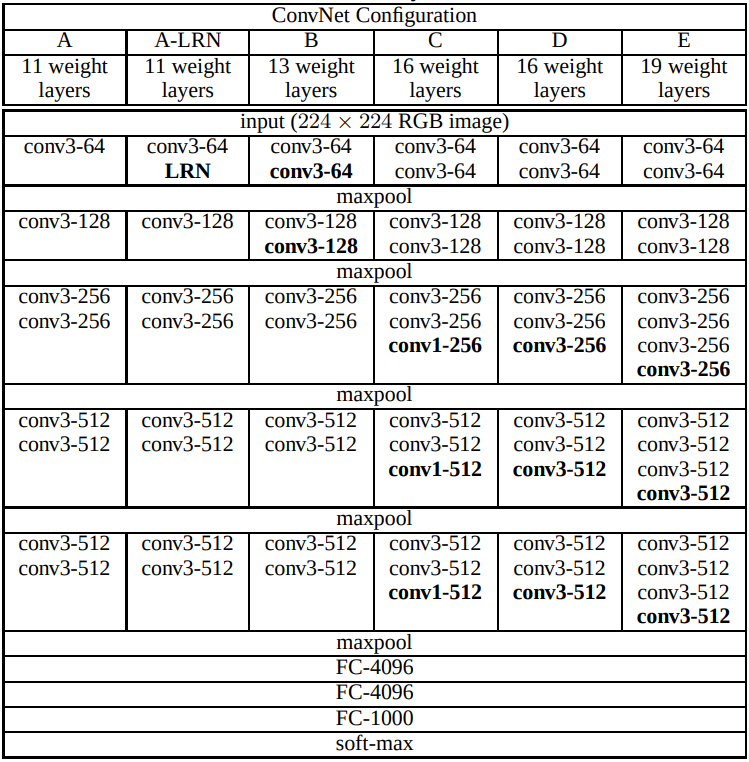

In [2]:
colab_working_dir = '/content/drive/MyDrive/Colab/'
display.Image(f"{colab_working_dir}imgs/vgg-configurations.png")

Configuration "D" (VGG16) is the most popular amongst these configurations. VGG11, VGG13, and VGG19 can also be found in the being used in the literature. Following the architecture of VGG16 for 224x224 RGB image. 

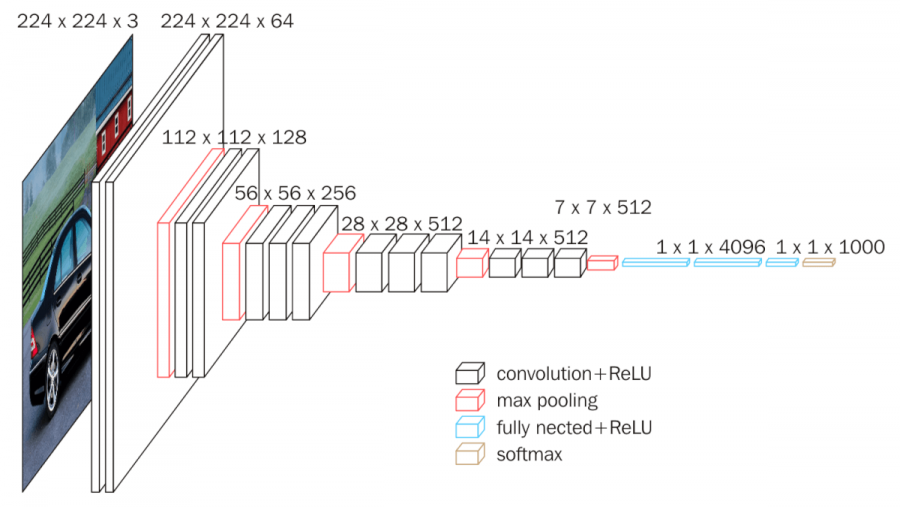

In [3]:
display.Image(f"{colab_working_dir}imgs/vgg.png")

## What is transfer learning?
In transfer learning, we first train a base network on a base dataset and task, and then we repurpose the learned features, or transfer them, to a second target network to be trained on a target dataset and task. This process will tend to work if the features are general, meaning suitable to both base and target tasks, instead of specific to the base task.

In simple terms, the act of using a pre-trained model to transfer knowledge from one task to another is called transfer learning. In thoery, these pre-trained models have already learned high-level features and this means we don't have to repeat the same training for our task. In some references, fine-tuning and transfer learning are used interchangeably. 

# Model Definition
There are two important things in VGG that needs some attention: `AdaptiveAvgPool2d` and `BatchNorm2d`.

`AdaptiveAvgPool2d`: In average-pooling or max-pooling, you essentially set the stride and kernel-size by your own, setting them as hyper-parameters. You will have to re-configure them if you happen to change your input size. In Adaptive Pooling on the other hand, we specify the output size instead and the stride and kernel-size are automatically selected to adapt to the needs.

`BatchNorm2d` : Batch normalisation is a method that makes training the deep neural networks faster and more stable. It consists of normalising the hidden layer activation vectors using mean and variance of the current batch. As our model begins to train and the parameters change. As a consequnece mean and std output by each layer will also change. A change in mean and std of the output of one layer will cause a change in mean and std for all following layers. This change in the distributions of internal nodes of a deep network, in the course of training, is known as Internal Covariate Shift and batch normalisation addresses it. 

In [4]:
# We want to train our model on a hardware accelerator like the GPU, if it is available.
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using {device} device")
vgg16 = models.vgg16_bn(pretrained=True)
summary(vgg16, (3, 224, 224), device = "cpu")

Using cuda device


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [5]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

The whole network is divided into two sequential layers. One extracts the `features` from the image and the other `classfies` based on observed features. The features are convolutional layers and the classfifier has linear layers. This model is trained on ImageNet dataset that has 224x224 color images with 1000 classes, therefore the final output layer is 1000 dimensional vector. The CIFAR10 dataset has 10 classes so we need to modify the final layer of this network.

In [6]:
# get the input dimension of the last layer, in this case it is 4096
in_features = vgg16.classifier[-1].in_features
out_features = 10 # CIFAR10 dataset
last_layer = nn.Linear(in_features, out_features)
vgg16.classifier[-1] = last_layer
print(vgg16.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)


We also want to visualise the features generated by the VGG16 model but the pre-trained model doesn't return them. We can create the model VGG16 model here that returns the intermediate feature vectors and can load the weights from the pre-trained network. 

In [7]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [8]:
vgg16_config: List[Union[str,int]] = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

In [9]:
def get_vgg_layers(config, batch_norm):
    layers = []
    in_channels = 3
    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c
    return nn.Sequential(*layers)

In [10]:
vgg16_layers = get_vgg_layers(vgg16_config, batch_norm=True)

In [11]:
net = VGG(vgg16_layers, 10)
net = net.to(device)
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [12]:
net.load_state_dict(vgg16.state_dict())

<All keys matched successfully>

In [13]:
# The number of images in a mini-batch
batch_size = 64
train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': 16}
if use_cuda:
    cuda_kwargs = {'num_workers': 2,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
    
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding=10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

In [14]:
# Store separate training and validations splits in ./data
training_set = torchvision.datasets.CIFAR10('./data',
    download=True,
    train=True,
    transform=train_transforms)

test_set = torchvision.datasets.CIFAR10('./data',
    download=True,
    train=False,
    transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
n_train = int(len(training_set) * 0.9)
n_valid = len(training_set) - n_train
train_set, validation_set = data.random_split(training_set, [n_train, n_valid])

In [16]:
validation_set = copy.deepcopy(validation_set)
validation_set.dataset.transform = test_transforms

In [17]:
train_loader = torch.utils.data.DataLoader(train_set, **train_kwargs)
validation_loader = torch.utils.data.DataLoader(validation_set, **train_kwargs)
test_loader = torch.utils.data.DataLoader(test_set, **test_kwargs)

# print the dataset
print(f'Size of training set = {len(train_set)}')
print(f'Size of validation set = {len(validation_set)}')
print(f'Size of test set = {len(test_set)}')
# print for dataset loader
print(f'Size of train loader = {len(train_loader)}') # ceil(len(training_set) / batch_size)
print(f'Size of validation loader = {len(validation_loader)}')
print(f'Size of test loader = {len(test_loader)}')

Size of training set = 45000
Size of validation set = 5000
Size of test set = 10000
Size of train loader = 704
Size of validation loader = 79
Size of test loader = 625


One Batch Dimension = torch.Size([64, 3, 224, 224]), Labels Dimension = torch.Size([64])


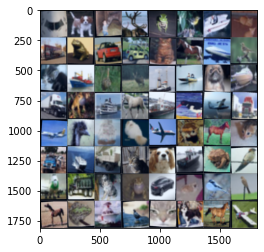

In [18]:
# Helper function for inline image display
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def matplotlib_imshow(img):
    img = normalize_image(img)
    img = img.permute((1,2,0))
    npimg = img.numpy()
    plt.imshow(npimg)
    
# Extract a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(f'One Batch Dimension = {images.shape}, Labels Dimension = {labels.shape}')

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid)

# Default log_dir argument is "runs" - but it's good to be specific
shutil.rmtree('runs/vgg16_experiment_1')
# torch.utils.tensorboard.SummaryWriter is imported above
writer = SummaryWriter('runs/vgg16_experiment_1')

# Write image data to TensorBoard log dir
writer.add_image(f'{batch_size} CIFAR10 Images', img_grid)

In [21]:
# %tensorboard --logdir '/content/drive/MyDrive/Colab/runs' --reload_interval 1

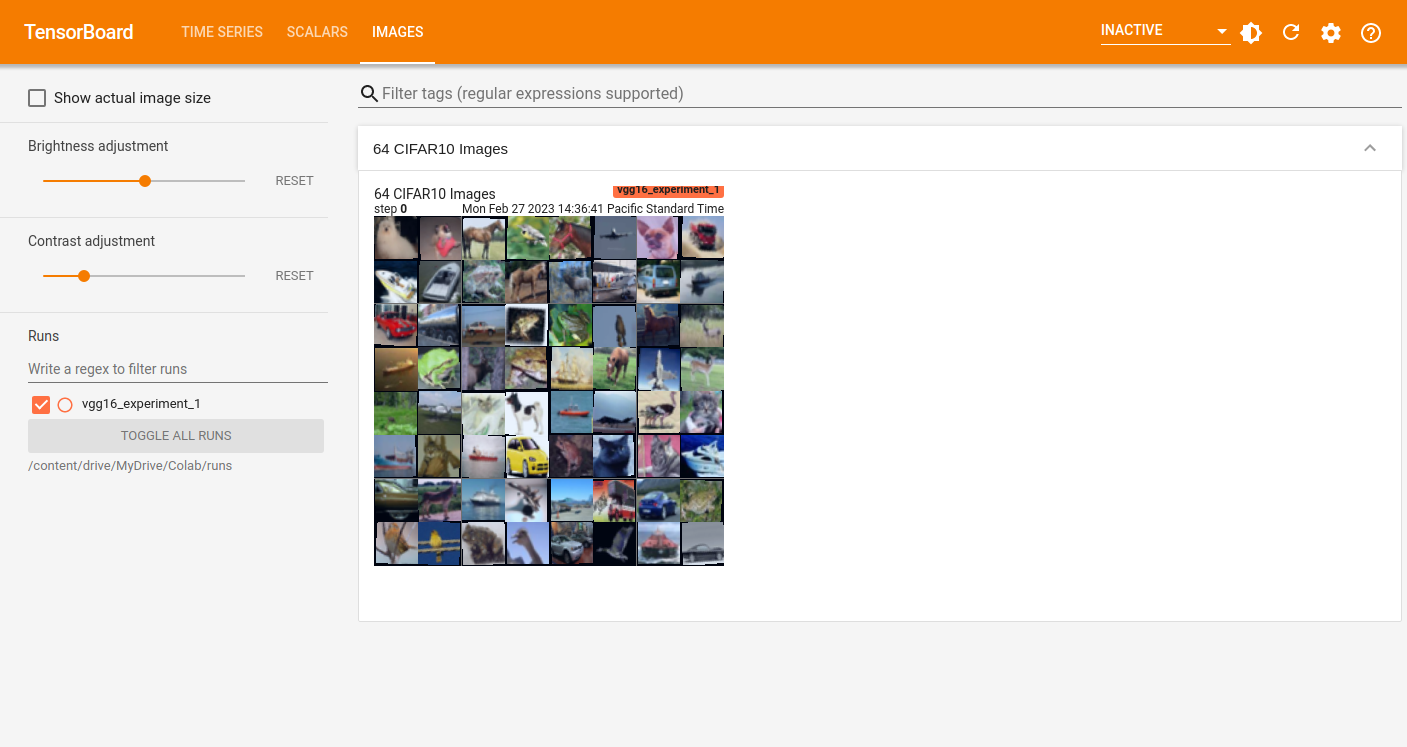

In [22]:
display.Image(f'{colab_working_dir}imgs/vgg16-images.png')

In [23]:
FOUND_LR = 5e-4

params = [
          {'params': net.features.parameters(), 'lr': FOUND_LR / 10},
          {'params': net.classifier.parameters()}
         ]

optimizer = optim.Adam(params, lr=FOUND_LR)

In [24]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [25]:
optimizer = optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [26]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    epoch_loss, epoch_acc = 0.0, 0.0
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        y_pred, _ = model(inputs)
        loss = criterion(y_pred, labels)
        acc = calculate_accuracy(y_pred, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        running_loss += loss.item()
        if (batch_idx+1) % 200 == 0:
            writer.add_scalar('Training_loss', running_loss,(epoch * len(train_loader) + batch_idx)*batch_size)
            print(f'Batch idx : {batch_idx}, Training Error : {running_loss}')
            running_loss = 0.0
    torch.save(model.state_dict(), 'models/vgg16-pretrained.pt')
    print(f'Training Error : {running_loss}')
    return epoch_loss / len(train_loader), epoch_acc / len(train_loader)

In [27]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss, test_acc = 0.0, 0.0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            y_pred,_ = model(data)
            loss = criterion(y_pred, target) 
            acc = calculate_accuracy(y_pred, target)
            test_loss += loss.item()
            test_acc += acc.item()
    n_iter = epoch * len(test_loader) * batch_size
    writer.add_scalar('Testing loss', test_loss, n_iter)
    print(f"Testing loss : {test_loss}")
    return test_loss / len(test_loader), test_acc / len(test_loader)

In [ ]:
EPOCHS = 10
for epoch in range(0,EPOCHS):
    train_loss, train_acc = train(net, train_loader, optimizer, criterion)
    valid_loss, valid_acc = test(net, validation_loader, criterion)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Batch idx : 199, Training Error : 142.7802200615406
Batch idx : 399, Training Error : 135.66217440366745
Batch idx : 599, Training Error : 132.82270866632462
Training Error : 63.18564000725746
Testing loss : 50.039463967084885
Epoch: 01
	Train Loss: 0.674 | Train Acc: 77.67%
	 Val. Loss: 0.633 |  Val. Acc: 79.03%
Batch idx : 199, Training Error : 109.41355147957802
Batch idx : 399, Training Error : 109.03585681319237
Batch idx : 599, Training Error : 101.22135579586029
Training Error : 56.4504719376564
Testing loss : 39.430002331733704
Epoch: 02
	Train Loss: 0.534 | Train Acc: 82.34%
	 Val. Loss: 0.499 |  Val. Acc: 83.60%
Batch idx : 199, Training Error : 93.77947790920734
Batch idx : 399, Training Error : 91.7884413599968
Batch idx : 599, Training Error : 88.24915908277035
Training Error : 49.56700283288956
Testing loss : 38.8341992944479
Epoch: 03
	Train Loss: 0.459 | Train Acc: 84.71%
	 Val. Loss: 0.492 |  Val. Acc: 83.17%
Batch idx : 199, Training Error : 82.65533757209778
Batch id

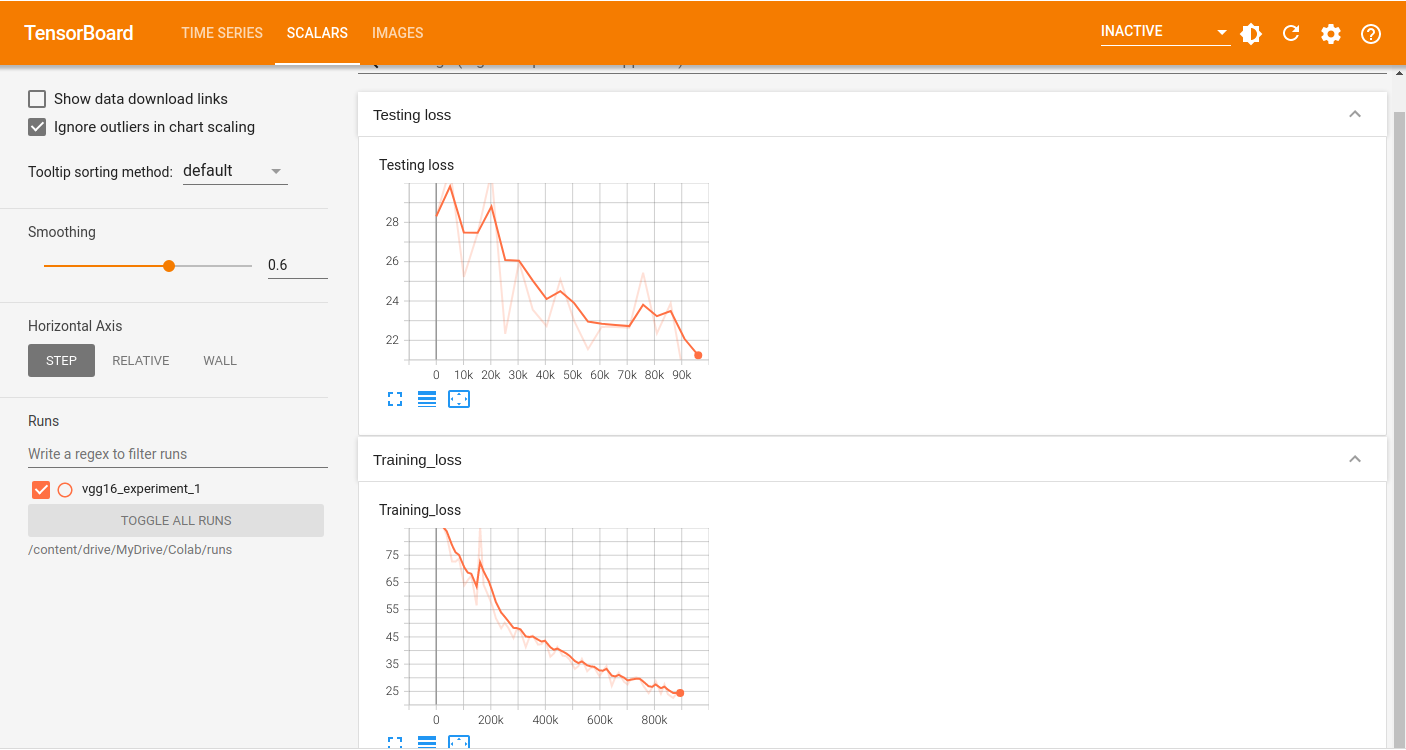

In [28]:
display.Image(f'{colab_working_dir}imgs/vgg16-loss.png')

Due to limited resources, I have trained this network for 20 epochs in a different google colab session and the weights were saved in my google drive. In the following line, I am loading the same model. 

In [29]:
net.load_state_dict(torch.load('/content/drive/MyDrive/Colab/models/vgg16-pretrained.pt'))
net = net.to(device)

## Results

We will plot the confusion matrix and look how the model is performing.

In [30]:
def get_predictions(model, iterator, device):
    model.eval()
    images = []
    labels = []
    probs = []
    t = transforms.Resize(32)
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim=-1)
            x = t(x)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)
    return images, labels, probs

In [31]:
images, labels, probs = get_predictions(net, test_loader, device)
pred_labels = torch.argmax(probs, 1)

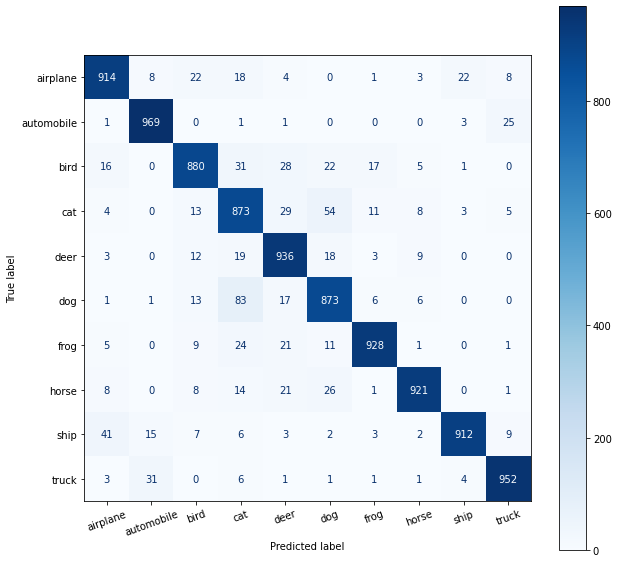

In [32]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog',
        'frog', 'horse', 'ship', 'truck')
def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=20)
    
plot_confusion_matrix(labels, pred_labels, classes)

The model is most confused between cats and dogs. Next, let's try to plot the most confident incorrect predictions.

In [33]:
corrects = torch.eq(labels, pred_labels)

In [34]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [35]:
def plot_most_incorrect(incorrect, classes, n_images):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize=(25, 20))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]
        image = normalize_image(image)
        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class}\n'
                     f'pred label: {incorrect_class}')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.4)

842


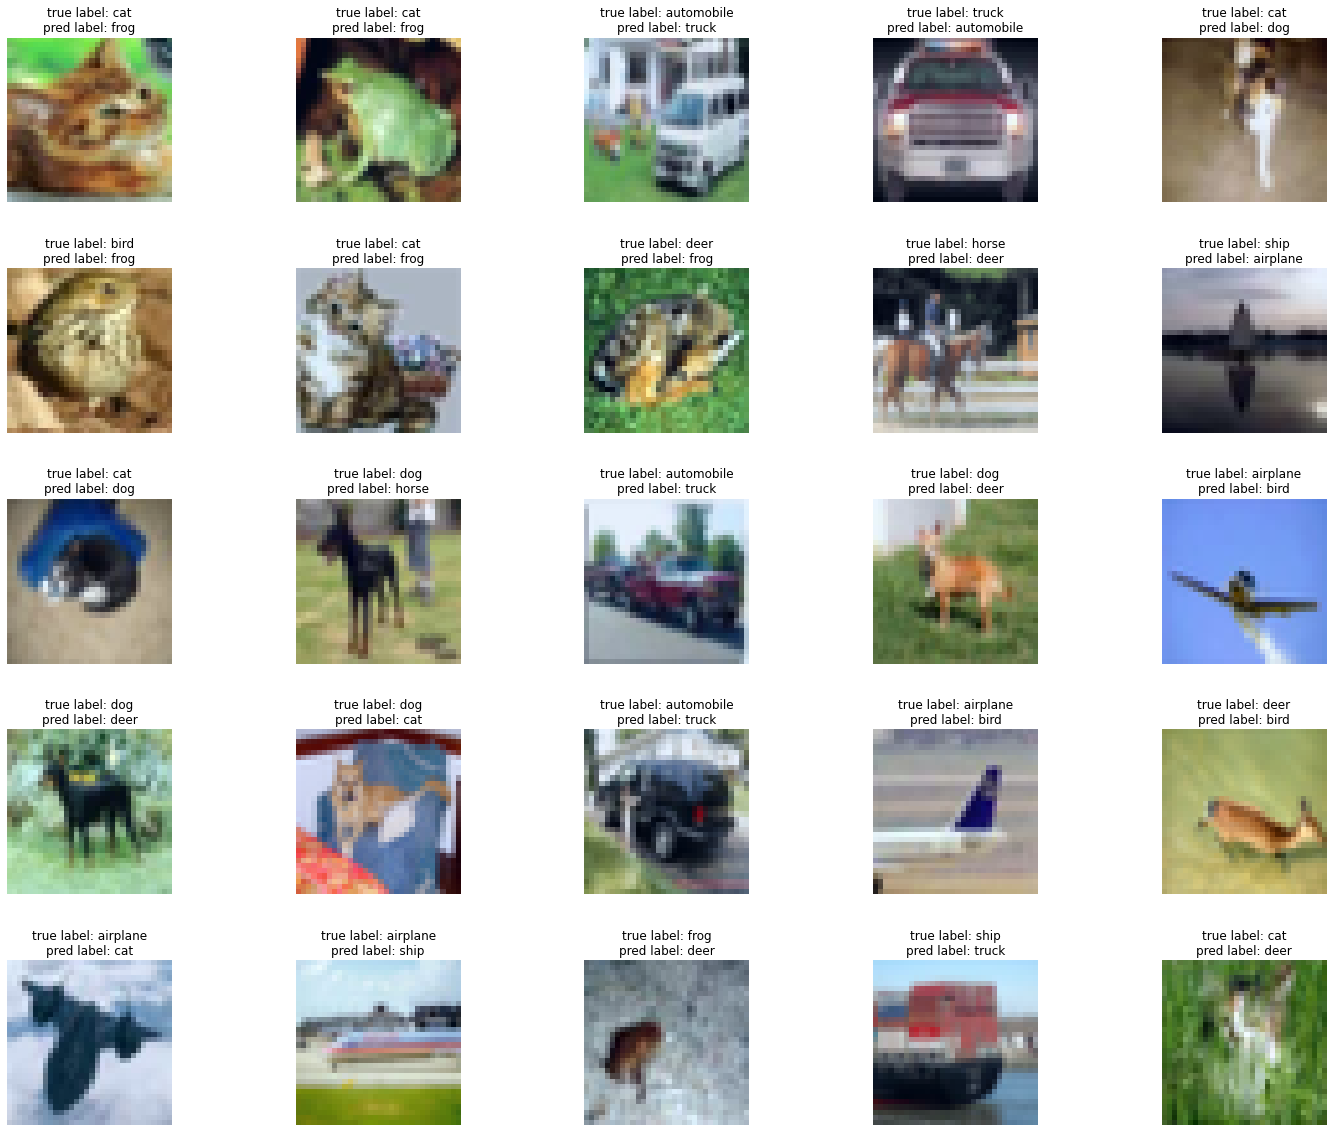

In [36]:
N_IMAGES = 32
print(len(incorrect_examples))
plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

Next, we visualise the filters to understand what features a filter has learnt. 

## Feature projection into lower dimensions


The features are higher dimensional vectors which divide different object classes into a set of clusters. For the current model, the each feature has a length of 25088. Let's plot these feature vectors using PCA and see if we get a clusters of different objects.

In [37]:
def get_representations(model, iterator, device):
    model.eval()
    outputs = []
    features = []
    labels = []
    images = []
    t = transforms.Resize(32)
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(iterator):
            x = x.to(device)
            y_pred, f = model(x)
            outputs.append(y_pred.cpu())
            features.append(f.cpu())
            labels.append(y)
            x = normalize_image(x)
            x = t(x)
            images.append(x)
    outputs = torch.cat(outputs, dim=0)
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    images = torch.cat(images, dim=0)
    return outputs, features, labels, images

outputs, intermediates, labels, images = get_representations(net, test_loader, device)

class_labels = [classes[label] for label in labels]
writer.add_embedding(intermediates, metadata = class_labels, label_img = images)
writer.flush()

From PCA visualisation, we can see that there are clusters amongst different classes. For example, all the airplanes, automobiles are together in the feature vector visualisations.  

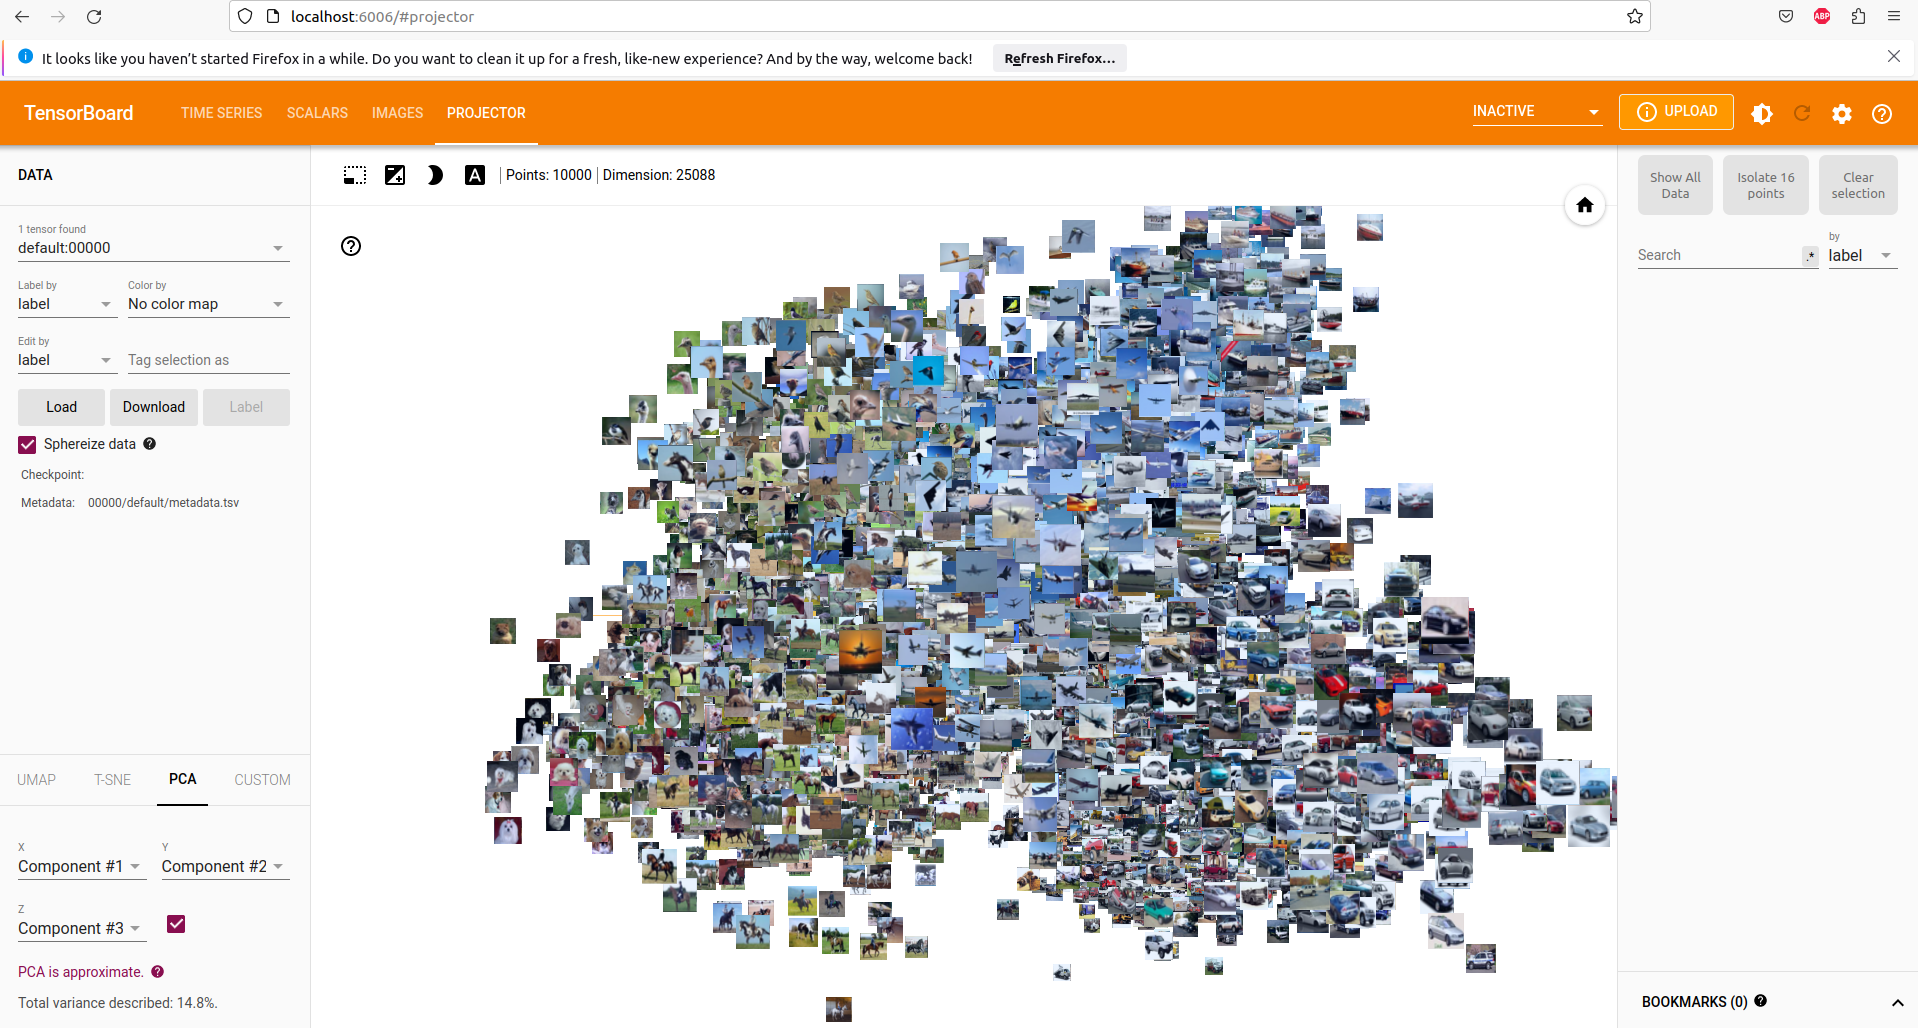

In [38]:
display.Image(f'{colab_working_dir}imgs/vgg16-projector.png')

### Weight Visualisations

Finally, we take a look at the filters of the trained network.  

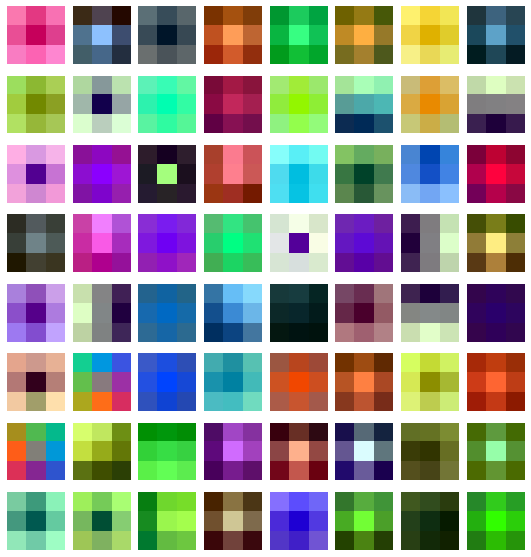

In [39]:
def plot_filters(filters):
    filters = filters.cpu()
    n_filters = filters.shape[0]
    cell_size = int(np.sqrt(n_filters))
    fig = plt.figure(figsize=(20, 10))
    for i in range(cell_size*cell_size):
        image = filters[i]
        image = normalize_image(image)
        ax = fig.add_subplot(cell_size, cell_size, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')
    fig.subplots_adjust(wspace=-0.9)
filters = net.features[0].weight.data
plot_filters(filters)

## References:
- Simonyan, Karen, and Andrew Zisserman. "Very deep convolutional networks for large-scale image recognition." arXiv preprint arXiv:1409.1556 (2014).
- Pytorch VGG16 : https://github.com/bentrevett/pytorch-image-classification/blob/master/4_vgg.ipynb